## Using Convolution Neural Nets to Tell the Status of a Draw Bridge

For a mini-project, I thought it would be interesting to make a convolution neural net (CNN) to tell if a local draw bridge is up or down and tweet any time the bridge status changes. Outline of the project:</br>
* Gather image data from an online source
* Label and preprocess the data
* Learn Keras and implement a CNN using the Keras package
* Tweet the status of the bridge

Packages used: numpy, TensorFlow, tweepy, PIL, pickle, pandas, matplotlib, and Keras.

### 1. Gather Image Data

There is a webcam that looks out at that bridge. The webcam has a live video stream and a page that periodically updates a static image of the bridge. I used images from the latter. Typically, this would be done by using a package like BeautifulSoup, searching through the html for the img tag, and grabbing the proper image. However due to how the webpage was embedded--the bridge image was not labelled with an image tag--I used a different approach. A page on the site would show the image and have a modified link to where the image is available. The link to the image would update roughly every 24 hours. I had to handle 404 errors (page not found) to find the new image link and start downloading images. I grabbed an image roughly every minute.

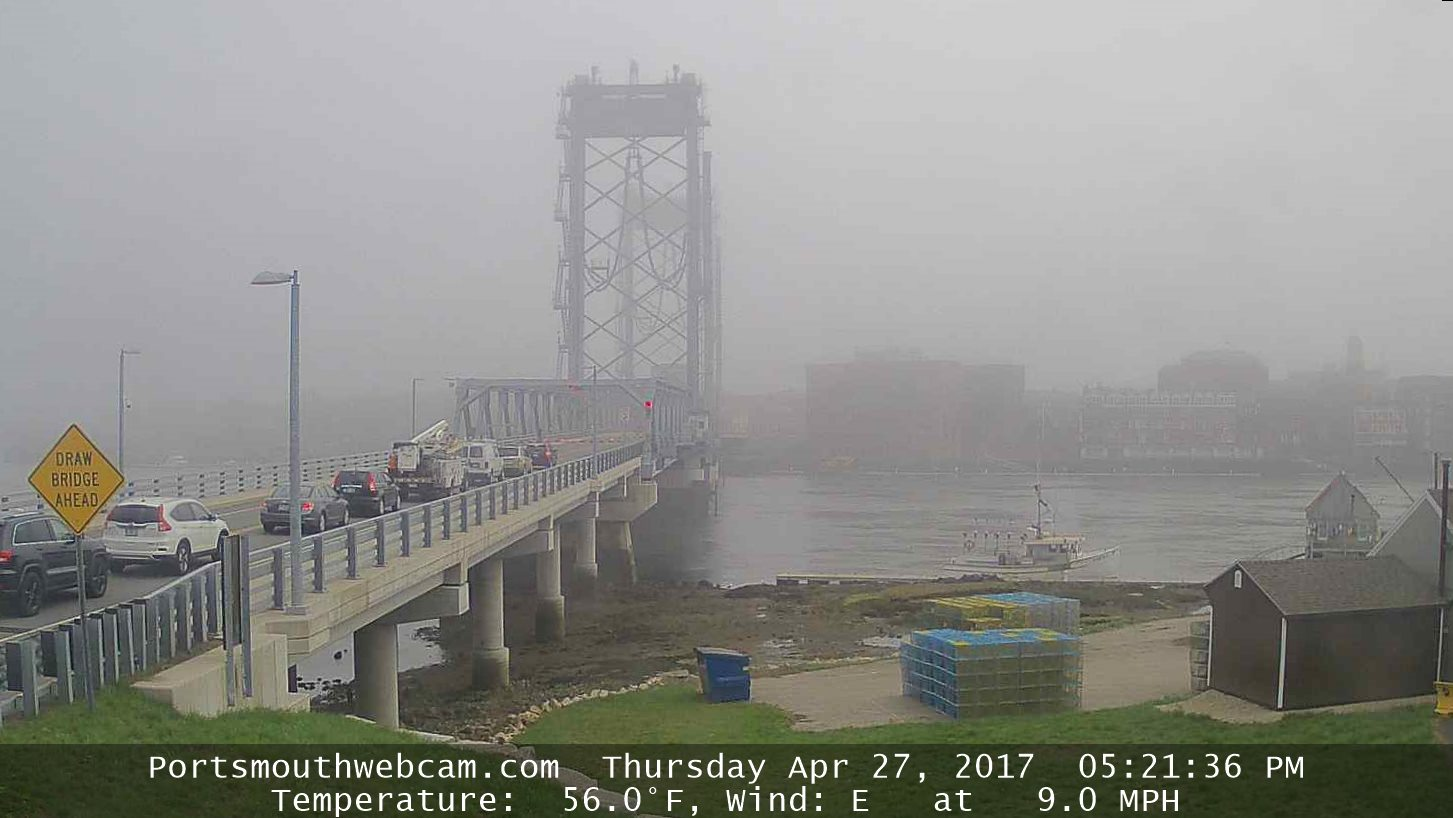

In [4]:
#sample image
from IPython.display import Image
Image("test_image_red.jpg")

In [ ]:
import urllib.request
import time
import urllib.request
from bs4 import BeautifulSoup

#link to image periodically changes. On a 404 error, call this function to get the new link
def change_img_url():
    try:
        page = BeautifulSoup(urllib.request.urlopen("http://www.portsmouthwebcam.com/kates/katebig.php"),"lxml")
    except urllib.error.URLError as err:
        print("urlib error", err)
        return None
    except BaseException as e:
        print("chang_img_url error",e)
        return None
    temp_text = page.text
    z1 = temp_text.find('iptimelapse')
    z2 = temp_text.find('.jpg') + 4
    if z1 != -1 and z2 != -1:
        print("new url",temp_text[z1:z2])
        return(temp_text[z1:z2])
    return None

#grab the image, save to file
def get_image(url_end):
    file_name = "memorial_bridge/" + str(int(time.time())) + ".jpg" 
    url = "http://www.portsmouthwebcam.com/kates/" + url_end
    try: 
        resource = urllib.request.urlopen(url)
        
        output = open(file_name,"wb")
        try:
            output.write(resource.read())
        except BaseException as e:
            print("Exception", e)
        output.close()
        return True
    
    except urllib.error.HTTPError as err:
        if err.getcode() == 404:
            print("http error 404 ")
            return False
        else:
            print("HTTP error " + str(err.getcode()) )
        return True
    except urllib.error.URLError as err:
        print("urlib error", err)
        return True
    except BaseException as e:
        print("Exception", e)
        return True

    return True
    
time_difference = 60
old_time = time.time() - time_difference
url_img_end = change_img_url()#'iptimelapse.com_7781_camera2.jpg'# 
time.sleep(5)

while True:
    current_time = time.time()
    if current_time - old_time > time_difference:
        old_time = current_time
        if url_img_end == None:
            url_img_end = change_img_url()
            old_time = current_time - 30 #ie get new image in 30 seconds
        else:
            get_image_result = get_image(url_img_end)
            #break
            if get_image_result == False: #url has changed get the new url
                url_img_end = None
                time.sleep(30)
                url_img_end = change_img_url()

            #old_time = current_time - 60 #ie get new image in 60 seconds
        #break
    time.sleep(1)

The above code is relatively straight forward. Obviously the error handling is poorly done. Rather than due a for loop, it would be better to have the code on a server doing a CRON job but I'm not currently renting any server space.

### 2. Label and Preprocess the Data

After running the above script and gathering about 7,500 images, the next step is labelling and preprocessing the data. While a human can easily tell if the bridge is up or down, I didn't want to have to look at 7,500 images. I considered some unsupervised learning techniques like K Means but couldn't come up with a good method. Instead I took the simplest possible approach: examining the traffic light. I cropped the image to take two very small patches of each image. The patches I focused on are where the red light and the green light light up on the side of the bridge. Then by comparing the means of the rgb (red, green, blue) channels I could tell if the light is red (bridge is up) or not (bridge is down). While this isn't the most effective method, it works. I was able to label the images and only had to manually check like 200 or so.

In [ ]:
import numpy as np
import pickle
from PIL import Image
import os

base_directory = 'memorial_bridge' 

#gets the list of files in a directory
def get_file_list(dir_name):    
    return os.listdir(dir_name)
    
#crops the images. in this case takes two 4x4 patches that focus on the green and red light of the bridge's vertical
#traffic light
def crop_images(image_name):
    try:
        original = Image.open(image_name)
        width, height = original.size   # Get dimensions
        #green light mini settings: 
        left = 646
        top = 413
        right = width - (width-left) + 4
        bottom = height - (height-top) + 4
        cropped_example_1 = original.crop((left, top, right, bottom))
        #cropped_example_1.show()
        #red light mini settings: 
        left = 646
        top = 402
        right = width - (width-left) + 4
        bottom = height - (height-top) + 4
        cropped_example_2 = original.crop((left, top, right, bottom))
        #cropped_example_2.show()
        return cropped_example_1,cropped_example_2
    except BaseException as e:
        print("crop failed image " + str(e.args) + image_name)
        return None, None

#turn the image into an array of data
def image_to_array(image):
    return np.asarray(image,dtype="int32")

image_list = get_file_list(base_directory)
image_dict = {}

#loop through the directory of images, grab the two small patches, convert into numpy data, save to pickle
for x in image_list:
    image_name = base_directory + "/" + x
    img1, img2 = crop_images(image_name)
    if img1 != None:
        img_array1 = image_to_array(img1)
        img_array2 = image_to_array(img2)
        image_dict[x] = (img_array1,img_array2)

#save the data
pickle.dump( image_dict, open( "cropped_g_r_image_dict.p", "wb" ) ) 

Once the data is in array format, I converted it to a pandas data frame to explore and see how to distinguish between the bridge when it is down (green traffic light) and up (red traffic light). I found the best method was to find the 'green_diff' and 'red_diff' below. These are the mean of the red channel minus the mean of the green and blue channels combined. red_diff is for the patch focused on the red traffic light. green_diff is for the patch focused on the green traffic light. In theory, when the red light is on, this will result in a large number for red_diff and around 0 for green_diff (since the green light is off). When the green light is on, green_diff should be negative and red_diff should be around 0 (since the red light is off). In practice it was a bit more complicated.

In [6]:
import pandas as pd
import numpy as np
import pickle

light_crop = pickle.load(open('cropped_g_r_image_dict.p', mode='rb'))

image_id =[]
green_r = []
green_b = []
green_g = []
green_diff = []
red_r = []
red_g = []
red_b = []
red_diff = []

for x in light_crop:
    image_id.append(x)
    green = light_crop[x][0]
    mean_g = np.round( np.mean(np.mean(green,axis=0),axis=0),1)
    green_r.append(mean_g[0])
    green_g.append(mean_g[1])
    green_b.append(mean_g[2])
    green_diff.append(mean_g[0] - (mean_g[1] +mean_g[2])/2. )
    red = light_crop[x][1]
    mean_r = np.round( np.mean(np.mean(red,axis=0),axis=0),1)
    red_r.append(mean_r[0])
    red_g.append(mean_r[1])
    red_b.append(mean_r[2])
    red_diff.append(mean_r[0] - (mean_r[1] +mean_r[2])/2. )

df = pd.DataFrame({"0_id":image_id, "1_rdiff":red_diff,"1_gdiff":green_diff,
                   "2_g_r":green_r,"2_g_g":green_g,"2_g_b":green_b,
                   "2_r_r":red_r,"2_r_g":red_g,"2_r_b":red_b})
df.head()

,0_id,1_gdiff,1_rdiff,2_g_b,2_g_g,2_g_r,2_r_b,2_r_g,2_r_r
0,1493806491.jpg,-5.7,15.15,108.9,160.3,128.9,109.4,109.9,124.8
1,1494035857.jpg,-25.4,-217.55,247.4,253.4,225.0,230.5,208.8,2.1
2,1493858776.jpg,-41.6,-179.25,249.6,253.4,209.9,204.2,177.3,11.5
3,1494067058.jpg,-29.3,-12.45,192.9,191.7,163.0,124.9,115.2,107.6
4,1493436995.jpg,-56.5,-189.00,251.6,252.6,195.6,219.6,186.6,14.1


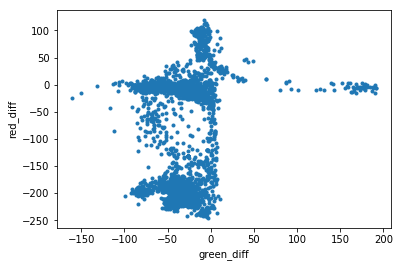

In [9]:
import matplotlib.pyplot as plt
plt.plot(df['1_gdiff'],df['1_rdiff'],'.')
plt.ylabel('red_diff')
plt.xlabel('green_diff')
plt.show()

Above is a plot of the data. In general, images with greater than 10 red_diff or greater than 10 green_diff are from when the bridge is up. </br>

In theory it should be roughly two clusters with one cluster being low red_diff and 0 green_diff (bridge down) and one cluster at high red_diff and 0 green_diff (bridge up). In practice, it was a bit messy. Possibly because the cropped image patches were too small. This led to some odd behavour. For example the images with roughly 0 red_diff and positive green_diff are due to images taken at night where the red light is very bright. The crop of the red light is all basically white pixels so the rgb channel is basically 255,255,255 resulting in a 0 or low red_diff. However the green_diff is very high because the red light is so bright, that it bleeds into the patch where the green traffic light is and causes many of those pixels to become red.</br>

Most of the data could be sorted automatically but I had to manually check a few hundred images from where the red_diff is positive but close to 0. Images early in the morning caused some issues so for regions I was unsure about, I copied the images into a test directory, looked through them and moved them their proper directories (bridge down/bridge up).

In [ ]:
#code for sorting
#Manual check: copy images to a test directory, sort through them when necessary to manually see if bridge is up or down
#Auto sort: move images to directory saying if bridge is up or down

import shutil

image_base = "memorial_bridge/"
dir_up = "memorial_bridge_up"
dir_down = "memorial_bridge_down"
dir_test = "memorial_test"

#temp_list = df[(df['1_gdiff'] > 30) & (df['1_rdiff'] <= 20)]['0_id'] DONE
#temp_list = df[(df['1_gdiff'] < 1000) & (df['1_rdiff'] > 20)]['0_id'] sorted, don't rerun
#temp_list = df[(df['1_gdiff'] < 1000) & (df['1_rdiff'] > 10) & (df['1_rdiff'] <= 20)]['0_id'] sorted don't rerun
#temp_list = df[(df['1_gdiff'] > -10) & (df['1_gdiff'] <= 30) & (df['1_rdiff'] > 0) & (df['1_rdiff'] <= 10)]['0_id'] #sorted dont rerun
#temp_list = df[(df['1_gdiff'] > -10) & (df['1_gdiff'] <= 30) & (df['1_rdiff'] > -10) & (df['1_rdiff'] <= 0)]['0_id'] #all green
#temp_list = df[ (df['1_gdiff'] <= -10) & (df['1_rdiff'] > 0) & (df['1_rdiff'] <= 10)]['0_id']  #all green
temp_list = df[ (df['1_gdiff'] < 10) & (df['1_rdiff'] < 0)]['0_id'] 
print(len(temp_list))

for i in temp_list:
    temp_name = image_base + i
    
    #move images to test directory for manual check
    #shutil.copy2(temp_name,dir_test)
    
    #move images directly to labelled directory
    #shutil.copy2(temp_name,dir_down)

The next preprocessing step was to crop the images and move them into the directory format useful for the Keras CNN implementation. The directory format is:
* data/train/up
* data/train/down
* data/validation/up
* data/validation/down

By storing the data in that format, Keras can do some neat tricks like auto-label the data, tell how many classes there are, and augment the data by generating similar images (more on this later). </br>

The code for cropping and copying the images over is straight-forward. I took a 400x400 patch from each image that focues on the bridge, and moved those cropped images to the proper directory. About 20% of the images were randomly put into the validation set.

In [ ]:
import numpy as np
import pickle
from PIL import Image
import os
import random

directory_test = 'memorial_test'
directory_up = 'memorial_bridge_up'
directory_down = 'memorial_bridge_down'
directory_up_train = 'memorial_data/train/up'
directory_down_train = 'memorial_data/train/down'
directory_up_val= 'memorial_data/validation/up'
directory_down_val = 'memorial_data/validation/down'

def get_file_list(dir_name):    
    return os.listdir(dir_name)

def crop_images(image_name):
    try:
        original = Image.open(image_name)
        width, height = original.size   # Get dimensions
        left = 350
        top = 100
        right = width - (width-left) + 400
        bottom = height - (height-top) + 400
        cropped_example_1 = original.crop((left, top, right, bottom))
        #cropped_example_1.show()
        return cropped_example_1
    except BaseException as e:
        print("crop failed image " + str(e.args) + image_name)
        return None
    
random.seed(0)

file_name_base = directory_down
file_names = get_file_list(directory_down)

for x in file_names:
    if x == 'Thumbs.db':
        continue 
    image_name = file_name_base + "/" + x
    img_temp = crop_images(image_name)
    if random.uniform(0.,1.0) <= 0.2:
        file_name = directory_down_val + "/" + x
    else:
        file_name = directory_down_train + "/" + x
    img_temp.save(file_name,"JPEG")

## 3. Keras Implementation of a CNN

Prior to this, I had used TensorFlow and heard of Keras but hadn't checked it out yet. The packages documentation (https://keras.io/) is straightforward and has some useful examples to get Keras up and running. I read through some of the documentation and tried applying this tutorial (https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to solve this problem. If you're interested in learning Keras I'd recommend reading the 'Home' and 'Getting Started' sections of the documentation and try playing around with a bunch of the sample models (and maybe reading a couple of the doc pages that supplment the models you are interested in). Then check out the image tutorial and implement those models. </br>

My goal with this section was to implement a CNN built from scratch and to implement a pre-built CNN and then fine-tune it with my specific data. While I was successful in the former, I struggled to get a good implementation of the latter. While the Keras tutorial on how to do this is great, the final code for it didn't run for me without some modifications that hurt the effectiveness of the pre-built models.</br>

### CNN Built From Scratch

Make sure you set up the directory format listed above and in the tutorial. I tried a different implementation where I tried turning the image data into a numpy array and saving it with pickle. This was intractable due to memory constraints. While there is a better way to do that, Keras makes it simple and you get to benefit from some of Keras's features like automatic training set shuffling and generating more image data to augment your data set. I decided not to augment my data set as I figured that would not help the CNN learn the bridge up and down positions as some transformations of images in the down position might look like images in the up position. </br>

Basically this is the code from the tutorial with a few modifications like the directory path, getting an exact count of the number of examples, and adding a ModelCheckpoint feature to save the best model.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint 


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'memorial_data/train'
validation_data_dir = 'memorial_data/validation'

nb_train_samples = len(get_file_list(directory_up_train)) + len(get_file_list(directory_down_train)) #2000
nb_validation_samples = len(get_file_list(directory_up_val)) + len(get_file_list(directory_down_val)) #800
epochs = 100
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255 )
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

checkpointer = ModelCheckpoint(filepath="mb_models/mb_simple_100_checkpoint.hdf5", verbose=1, save_best_only=True,period=5)

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[checkpointer])

#model.save_weights('mb_simple_convnet.h5')
model.save('mb_simple_convnet_100_epoc.h5')

### Prebuilt CNN

The tutorial walks through downloading already found weights of a VGG 16 layer CNN. The tutorial does this two ways. The first way is slicing off the fully connected layer and training that layer with your own data. The second way slices off a convolutional layer and the fully connected layer and involves more training.</br>

I was able to get the first implementation of the tutorial running both for his example and for my example. Some pointers by other people who implemented the code can help get the accuracy up on his example form 90% to 95% (https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069). However this type of net didn't generalize well to what I was working on resulted in 95% accuracy on the validation set. This is a poor result for my model since the bridge is in a down position 95% of the time and the model didn't improve past the 2nd epoch. I'm not sure whether this a failure on my part or due to the VGG net not generalizing well to my dataset. I'd guess the former, as I'm not sure if I labelled the data properly. The tutorial code basically labels the data by saying 'here's an array of half 0's and half 1's since the training set consists of an equal number of each.' My data skews 15 to 1 of down to up and I'm not sure if I did that properly in this implementation as I was left with sets of length unequal to what would be expected.</br>

The second implementation of the tutorial, I wasn't able to run successfully even on the cat and dog example set. I encountered some errors and even when I solved them (at least I thought I did) the model trained poorly and didn't improve as the epochs went on. Not sure where I went wrong.

In [ ]:
#pre build VGG model
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'memorial_data/train'
validation_data_dir = 'memorial_data/validation'
nb_train_samples = len(get_file_list(directory_up_train)) + len(get_file_list(directory_down_train)) #2000
nb_validation_samples = len(get_file_list(directory_up_val)) + len(get_file_list(directory_down_val)) #800
epochs = 50
batch_size = 16


def save_bottlebeck_features():
    #datagen = ImageDataGenerator(rescale=1. / 255)
    datagen = ImageDataGenerator(rescale=1., featurewise_center=True) #(rescale=1./255)
    datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)
    #datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(3,1,1)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    
#     train_labels = np.array(
#         [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))
    train_labels = np.array(
        [0] * len(get_file_list(directory_down_train)) + [1] * len(get_file_list(directory_up_train)))

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    #     validation_labels = np.array(
#         [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
    validation_labels = np.array(
        [0] * len(get_file_list(directory_down_val)) + [1] * len(get_file_list(directory_up_val)) )

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    
save_bottlebeck_features()
train_top_model()

## 4. Send Status Updates to Twitter

This part combines some code from prior sections and implments a very simple implementation of tweepy. To use tweepy, you'll need to get some keys which can be done by registering on twitter. To run the code below you'll need to get your own consumer_key, consumer_secret, access_token, and access_token_secret.</br>

Rough outline of the code: load the already trained CNN model, get a current image of the bridge, crop the image and feed it into the CNN and get a prediction of the status of the bridge. If this new status doesn't match the last status of the bridge, then tweet an update with the new bridge status.

In [37]:
from keras.models import load_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import tweepy
import urllib.request
import time
import urllib.request
from bs4 import BeautifulSoup
import shutil
from PIL import Image

#set up tweepy, you'll need your own keys to do your own implementation
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

# OAuth process, using the keys and tokens
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
 
# Creation of the actual interface, using authentication
api = tweepy.API(auth)

def tweet_status_update(status):
    if status == -1:
        api.update_status('Bridge status is unknown -- ' + str(time.ctime()) )
    elif status == 0:
        api.update_status('Bridge is down -- ' + str(time.ctime()))
    elif status == 1:
        api.update_status('Bridge is up -- ' + str(time.ctime()))

#link to image periodically changes. On a 404 error, call this function to get the new link
def change_img_url():
    try:
        page = BeautifulSoup(urllib.request.urlopen("http://www.portsmouthwebcam.com/kates/katebig.php"),"lxml")
    except urllib.error.URLError as err:
        print("urlib error", err)
        return None
    except BaseException as e:
        print("chang_img_url error",e)
        return None
    temp_text = page.text
    z1 = temp_text.find('iptimelapse')
    z2 = temp_text.find('.jpg') + 4
    if z1 != -1 and z2 != -1:
        print("new url",temp_text[z1:z2])
        return(temp_text[z1:z2])
    return None



#grab the image, save to file return 1 for image saved, 0 for not, -1 for get new url
def get_image(url_end):
    file_name = "memorial_bridge/" + str(int(time.time())) + ".jpg" 
    url = "http://www.portsmouthwebcam.com/kates/" + url_end
    try: 
        resource = urllib.request.urlopen(url)
        
        output = open(file_name,"wb")
        try:
            output.write(resource.read())
        except BaseException as e:
            print("Exception", e)
            return 0
        output.close()
        
        file_current = "memorial_current/current_img.jpg"
        shutil.copy2(file_name,file_current)
        return 1
        
#         output = open(file_current,"wb")
#         try:
#             output.write(resource.read())
#             output.close()
#             return 1
#         except BaseException as e:
#             print("Exception", e)
#         output.close()
#         return 0
    
    except urllib.error.HTTPError as err:
        if err.getcode() == 404:
            print("http error 404 ")
            return -1
        else:
            print("HTTP error " + str(err.getcode()) )
        return 0
    except urllib.error.URLError as err:
        print("urlib error", err)
        return 0
    except BaseException as e:
        print("Exception", e)
        return 0

    return 0

#crop the image
def crop_images(image_name):
    try:
        original = Image.open(image_name)
        width, height = original.size   # Get dimensions
        left = 350
        top = 100
        right = width - (width-left) + 400
        bottom = height - (height-top) + 400
        cropped_example_1 = original.crop((left, top, right, bottom))
        #cropped_example_1.show()
        cropped_example_1.save('memorial_current/current_crop_img.jpg',"JPEG")
        return 1
    except BaseException as e:
        print("crop failed image " + str(e.args) + image_name)
        return None


In [ ]:
#load the CNN
cnn_model = load_model('mb_simple_convnet_100_epoc.h5')
img_width, img_height = 150, 150

#-1 for unknown, 0 for down, 1 for up
bridge_status = -1    
time_difference = 60
old_time = time.time() - time_difference
url_img_end = change_img_url()#'iptimelapse.com_7781_camera2.jpg'# 
time.sleep(5)
file_current_path = "memorial_current/current_img.jpg"
file_current_crop_path = 'memorial_current/current_crop_img.jpg'

while True:
    current_time = time.time()
    if current_time - old_time > time_difference:
        old_time = current_time
        if url_img_end == None:
            url_img_end = change_img_url()
            old_time = current_time - 30 #ie get new image in 30 seconds
        else:
            get_image_result = get_image(url_img_end)
            if get_image_result == 1:
                cropped_img = crop_images(file_current_path)
                if cropped_img != None:
                    #print('reached here')
                    img = load_img(file_current_crop_path,False,target_size=(img_width,img_height))
                    x = img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    preds = cnn_model.predict_classes(x)
                    if preds[0] != bridge_status:
                        bridge_status = preds[0]
                        tweet_status_update(preds[0])
                        print('bridge status changed ', preds[0] , time.ctime())
                #break
            elif get_image_result == -1: #url has changed get the new url
                url_img_end = None
                time.sleep(30)
                url_img_end = change_img_url()

            #old_time = current_time - 60 #ie get new image in 60 seconds
        #break
    #break
    time.sleep(1)
    


new url iptimelapse.com_2445_camera2.jpg
1/1 [==============================] - 0s
bridge status changed  [0] Fri May 12 12:32:19 2017
1/1 [==============================] - 0s
bridge status changed  [1] Fri May 12 12:54:25 2017
1/1 [==============================] - 0s
bridge status changed  [0] Fri May 12 13:01:28 2017
1/1 [==============================] - 0s
bridge status changed  [1] Fri May 12 13:37:42 2017
1/1 [==============================] - 0s
bridge status changed  [0] Fri May 12 13:43:44 2017
1/1 [==============================] - 0s
